# Use VAEs to compress target population dynamics (OD and fluorescence)

Author: Zhengqing Zhou

Updated: 2025/06/13

In [ ]:
# We begin by importing the essentials
import numpy as np
import matplotlib.pyplot as plt

# We also setup torch for later usage.
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import trange
from torch.nn import functional as F
from torch import nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import time as timer
import pickle

# Configure GPU if available
if torch.cuda.is_available():

    device = "cuda:0"
else:
    device = "cpu"

display(device)

# VAE Network
The VAE network has 32 channels in the encoder, consisting of 3 convolutional layers, each followed by a leaky relu function, with kernel = 3, strid = 1, and padding = 1, so the time series (length of 168) will not get shortened during the convolutions; and two parallel linear layers to project the encoded time series to the mean value and var of the latent dimension, based on which a gaussian sampling will be done, generating the embedding of the data. The embedding is further decoded by a decoder of the symmetrical structure.

In [2]:
class VAE(nn.Module):

    def __init__(self, n_target, latent_dim):

        # Call parent model constructor and store hidden state variables.
        super().__init__()
        self.latent_dim = latent_dim
        self.n_target = n_target
        self.T = 168
        self.channels = 32
        
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=self.n_target, out_channels=self.channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
        )
        
        self.mean_map = nn.Linear(self.channels*self.T, self.latent_dim)
        
        self.std_map = nn.Linear(self.channels*self.T, self.latent_dim)
        
        self.fc_decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.channels*self.T),
            nn.LeakyReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(in_channels=self.channels, out_channels=self.n_target, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        )

    def sample(self, mean, log_var):
        """Sample a given N(0,1) normal distribution given a mean and log of variance."""

        # First compute the variance from the log variance.
        var = torch.exp(0.5 * log_var)

        # Compute a scaled distribution
        eps = torch.randn_like(var)

        # Add the vectors
        z = mean + var * eps

        return z

    def forward(self, X):
        """Forward propogate through the model, return both the reconstruction and sampled mean and standard deviation
        for the system.
        """
        pre_code = self.encoder(X)
        B, C, L = pre_code.shape
        flattened = pre_code.view(B, C * L)

        mu = self.mean_map(flattened)
        log_var = self.std_map(flattened)

        code = self.sample(mu, log_var)

        # Pass through FC layers before decoding
        post_code = self.fc_decoder(code)

        X_hat = self.decoder(post_code.view(B, C, L))

        return X_hat, code, mu, log_var

def vae_loss(x_hat, x, mu, log_var):
    "Compute the sum of BCE and KL loss for the distribution."
    
    # weight for the KL divergence
    alpha = 1e-4

    # Compute the reconstruction loss
    BCE = F.mse_loss(x_hat, x)

    # Compute the KL divergence of the distribution.
    KLD = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())

    return BCE + alpha*KLD

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# define utility functions
- load the data
- train, test the model

In [4]:
def train_model(model, data_loader, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for batch in data_loader:
        batch = batch.to("cuda:0")
        optimizer.zero_grad()
        pred, code, mu, log_var = model(batch)
        loss = vae_loss(pred, batch, mu, log_var)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

def test_model(model, data_loader):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to("cuda:0")
            pred, code, mu, log_var = model(batch)
            loss = vae_loss(pred, batch, mu, log_var)
            total_loss += loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

In [5]:
def get_data(n_target):
    X_train = np.load("Nano_target_dynamics_train.npy")[:,0:n_target,:]
    X_test = np.load("Nano_target_dynamics_test.npy")[:,0:n_target,:]
    return X_train, X_test

In [6]:
X_train,X_test = get_data(2)
print(X_train.shape,X_test.shape)

(709, 2, 168) (178, 2, 168)


# Example: training a single VAE model on the trial data

In [7]:
lr = 1e-3
lr_decay = 0.99
batch_size = 16
EPOCHS = 200
n_target = 5

n_embedding = 5
X_train, X_test = get_data(n_target)
X_train = torch.Tensor(X_train).float()
X_test = torch.Tensor(X_test).float()
train_loader = DataLoader(X_train,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(X_test,batch_size=batch_size,shuffle=False)

model = VAE(n_target,n_embedding)
model.to("cuda:0");
model.train()
print("model parameters: %1.1e"%count_parameters(model))
train_losses=[]
test_losses=[]
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
for ix_epoch in trange(EPOCHS):
    train_err=train_model(model, train_loader, optimizer)
    test_err=test_model(model, test_loader)
    train_losses.append(train_err)
    test_losses.append(test_err)
    # Exponential decay for learning rate
    lr *= lr_decay
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
print("training finished, with starting MSE %1.1e, and ending error %1.1e"%(test_losses[0],test_losses[-1]))

model parameters: 9.9e+04


  0%|          | 0/200 [00:00<?, ?it/s]

training finished, with starting MSE 1.7e-02, and ending error 5.9e-04


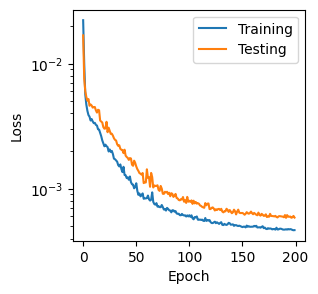

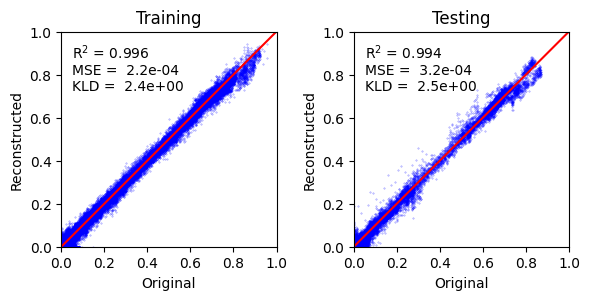

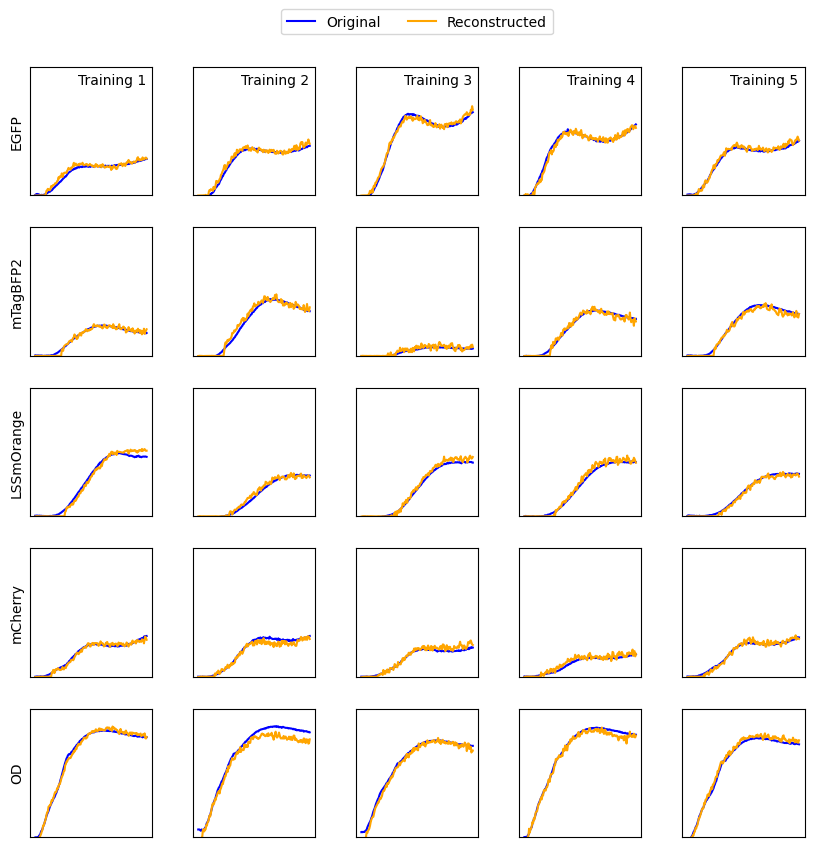

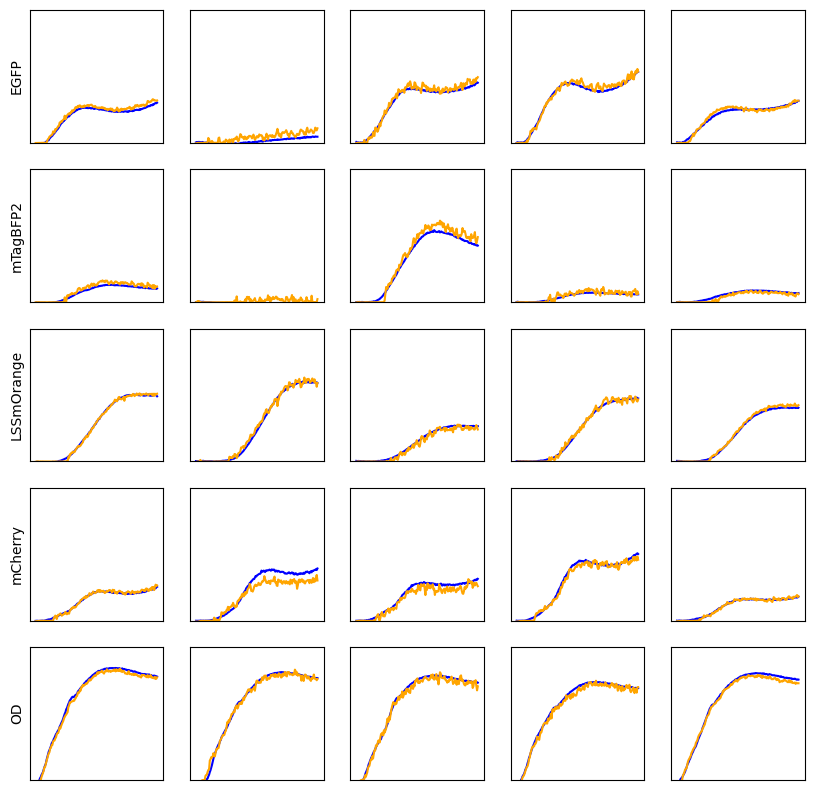

In [8]:
# Plotting the loss values
plt.figure(figsize=(3, 3))
plt.semilogy(train_losses, label='Training')
plt.semilogy(test_losses, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#rank both train and test data for visualization
train_data=torch.Tensor(X_train)
sums = train_data.sum(dim=(1,2))  # Shape: (B,)
ranked_indices_train = torch.argsort(sums,descending=True)  # Sort by total sum

test_data=torch.Tensor(X_test)
sums = test_data.sum(dim=(1,2))  # Shape: (B,)
ranked_indices_test = torch.argsort(sums,descending=True)  # Sort by total sum


with torch.no_grad():
    output_train, _, mu_train, logvar_train = model(train_data.to(device))
    output_test, _, mu_test, logvar_test = model(test_data.to(device))


output_train = output_train.cpu().numpy()
output_test = output_test.cpu().numpy()

# Percentage of data to visualize
percentage = 0.2
num_train_samples = int(len(train_data) * percentage)
num_test_samples = int(len(test_data) * percentage)

# Index into the data tensors
subset_train_data = train_data[:num_train_samples]
subset_test_data = test_data[:num_test_samples]

subset_train_pred = output_train[:num_train_samples]
subset_test_pred = output_test[:num_test_samples]

# Plotting the reconstructed data against the original data
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

# Training data plot
axs[0].scatter(subset_train_data.flatten(), subset_train_pred.flatten(), s=0.1, color='blue', alpha=0.5)
axs[0].plot([0,1], [0,1], 'r')  # y=x line
axs[0].set_xlim([0,1])
axs[0].set_ylim([0,1])
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlabel('Original')
axs[0].set_ylabel('Reconstructed')
axs[0].set_title('Training')

r2_train = r2_score(train_data.flatten(), output_train.flatten())
mse_train = np.square(train_data-output_train).mean()
KLD_train = -0.5 * torch.mean(1 + logvar_train - mu_train.pow(2) - logvar_train.exp())
axs[0].text(0.05, 0.95, f'R$^2$ = {r2_train:.3f}\nMSE = {mse_train: .1e}\nKLD = {KLD_train: .1e}', transform=axs[0].transAxes, verticalalignment='top')

# Testing data plot
axs[1].scatter(subset_test_data.flatten(), subset_test_pred.flatten(), s=0.1, color='blue', alpha=0.5)
axs[1].plot([0,1], [0,1], 'r')  # y=x line
axs[1].set_xlim([0,1])
axs[1].set_ylim([0,1])
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_xlabel('Original')
axs[1].set_ylabel('Reconstructed')
axs[1].set_title('Testing')

r2_test = r2_score(test_data.flatten(), output_test.flatten())
mse_test = np.square(test_data-output_test).mean()
KLD_test = -0.5 * torch.mean(1 + logvar_test - mu_test.pow(2) - logvar_test.exp())
axs[1].text(0.05, 0.95, f'R$^2$ = {r2_test:.3f}\nMSE = {mse_test: .1e}\nKLD = {KLD_test: .1e}', transform=axs[1].transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

# Additional Panels for Sample Data Trajectories
fig, axs = plt.subplots(n_target, 5, figsize=(10, 2*n_target))
FP = ["EGFP", "mTagBFP2", "LSSmOrange", "mCherry", "OD",]
# Training data trajectories
idx_show = np.random.choice(ranked_indices_train[0:20],5,replace=False)
for i,idx in enumerate(idx_show):
    for j in range(n_target):
        axs[j, i].plot(train_data[idx,j], color='blue')
        axs[j, i].plot(output_train[idx,j], color='orange')
        axs[j, i].set_ylim([0,1])
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])
        if i==0:
            axs[j,i].set_ylabel(FP[j])
    axs[0, i].text(x=0.95,y=0.95,s=f'Training {i + 1}',ha="right",va="top",transform=axs[0,i].transAxes)

axs[0, 2].plot([], label='Original', color='blue')
axs[0, 2].plot([], label='Reconstructed', color='orange')
axs[0,2].legend(loc="lower center",bbox_to_anchor=(0.5,1.2),ncol=2)
fig.subplots_adjust(hspace=0.25,wspace=0.33)

fig, axs = plt.subplots(n_target, 5, figsize=(10, 2*n_target))
# Testing data trajectories
idx_show = np.random.choice(ranked_indices_test[0:20],5,replace=False)
for i,idx in enumerate(idx_show):
    for j in range(n_target):
        axs[j, i].plot(test_data[idx,j], color='blue')
        axs[j, i].plot(output_test[idx,j], color='orange')
        axs[j, i].set_ylim([0,1])
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])
        if i==0:
            axs[j,i].set_ylabel(FP[j])
    axs[0, i].text(x=0.95,y=0.95,s=f'Test {i + 1}',ha="right",va="top",transform=axs[1,i].transAxes)

plt.show()


# Visualize the training outcome

## Alternatively, you can load a trained model and see the reconstruction quality

In [9]:
n_target = 5
n_embedding = 5
trial = 1
model = VAE(n_target,n_embedding)
model.to("cuda:0");
model.load_state_dict(
    torch.load(
        "./vae_models/T%i_E%i_trial%i.pth"%
        (n_target,n_embedding,trial),weights_only=True)
)

<All keys matched successfully>

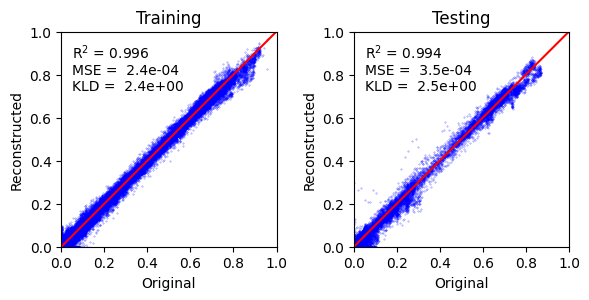

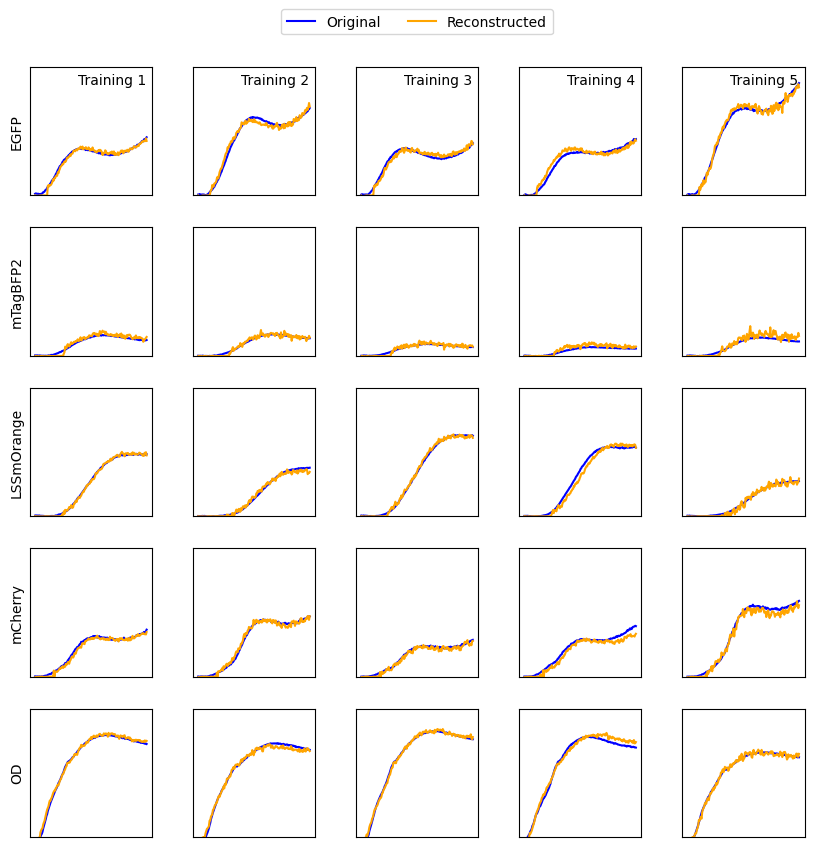

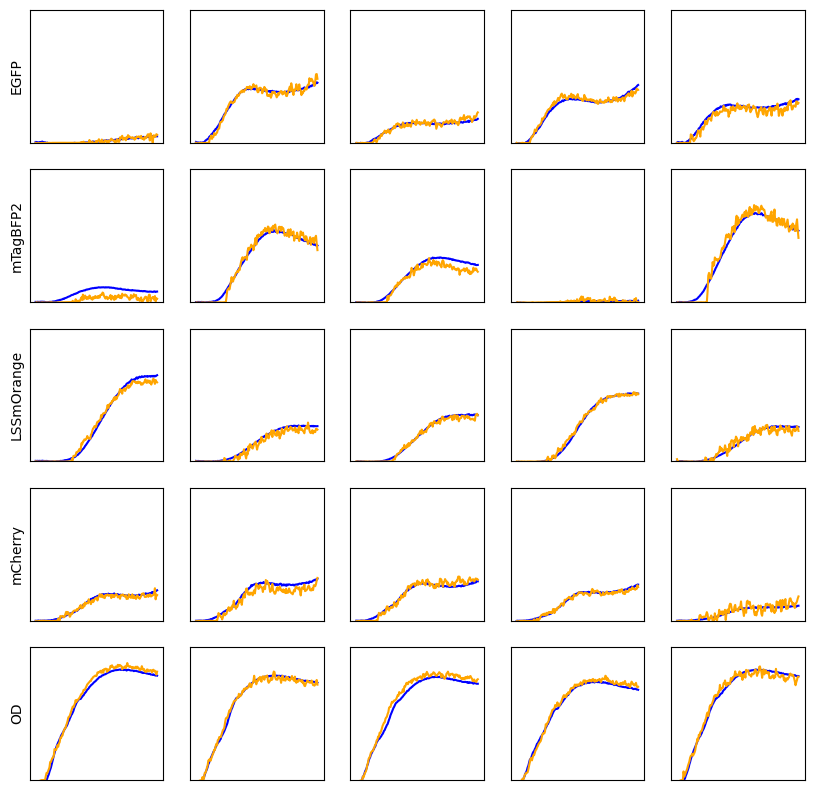

In [10]:
X_train, X_test = get_data(n_target)
X_train = torch.Tensor(X_train).float()
X_test = torch.Tensor(X_test).float()
train_loader = DataLoader(X_train,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(X_test,batch_size=batch_size,shuffle=False)

#rank both train and test data for visualization
train_data=torch.Tensor(X_train)
sums = train_data.sum(dim=(1,2))  # Shape: (B,)
ranked_indices_train = torch.argsort(sums,descending=True)  # Sort by total sum

test_data=torch.Tensor(X_test)
sums = test_data.sum(dim=(1,2))  # Shape: (B,)
ranked_indices_test = torch.argsort(sums,descending=True)  # Sort by total sum


with torch.no_grad():
    output_train, _, mu_train, logvar_train = model(train_data.to(device))
    output_test, _, mu_test, logvar_test = model(test_data.to(device))


output_train = output_train.cpu().numpy()
output_test = output_test.cpu().numpy()

# Percentage of data to visualize
percentage = 0.2
num_train_samples = int(len(train_data) * percentage)
num_test_samples = int(len(test_data) * percentage)

# Index into the data tensors
subset_train_data = train_data[:num_train_samples]
subset_test_data = test_data[:num_test_samples]

subset_train_pred = output_train[:num_train_samples]
subset_test_pred = output_test[:num_test_samples]

# Plotting the reconstructed data against the original data
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

# Training data plot
axs[0].scatter(subset_train_data.flatten(), subset_train_pred.flatten(), s=0.1, color='blue', alpha=0.5)
axs[0].plot([0,1], [0,1], 'r')  # y=x line
axs[0].set_xlim([0,1])
axs[0].set_ylim([0,1])
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlabel('Original')
axs[0].set_ylabel('Reconstructed')
axs[0].set_title('Training')

r2_train = r2_score(train_data.flatten(), output_train.flatten())
mse_train = np.square(train_data-output_train).mean()
KLD_train = -0.5 * torch.mean(1 + logvar_train - mu_train.pow(2) - logvar_train.exp())
axs[0].text(0.05, 0.95, f'R$^2$ = {r2_train:.3f}\nMSE = {mse_train: .1e}\nKLD = {KLD_train: .1e}', transform=axs[0].transAxes, verticalalignment='top')

# Testing data plot
axs[1].scatter(subset_test_data.flatten(), subset_test_pred.flatten(), s=0.1, color='blue', alpha=0.5)
axs[1].plot([0,1], [0,1], 'r')  # y=x line
axs[1].set_xlim([0,1])
axs[1].set_ylim([0,1])
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_xlabel('Original')
axs[1].set_ylabel('Reconstructed')
axs[1].set_title('Testing')

r2_test = r2_score(test_data.flatten(), output_test.flatten())
mse_test = np.square(test_data-output_test).mean()
KLD_test = -0.5 * torch.mean(1 + logvar_test - mu_test.pow(2) - logvar_test.exp())
axs[1].text(0.05, 0.95, f'R$^2$ = {r2_test:.3f}\nMSE = {mse_test: .1e}\nKLD = {KLD_test: .1e}', transform=axs[1].transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

# Additional Panels for Sample Data Trajectories
fig, axs = plt.subplots(n_target, 5, figsize=(10, 2*n_target))
FP = ["EGFP", "mTagBFP2", "LSSmOrange", "mCherry", "OD",]
# Training data trajectories
idx_show = np.random.choice(ranked_indices_train[0:20],5,replace=False)
for i,idx in enumerate(idx_show):
    for j in range(n_target):
        axs[j, i].plot(train_data[idx,j], color='blue')
        axs[j, i].plot(output_train[idx,j], color='orange')
        axs[j, i].set_ylim([0,1])
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])
        if i==0:
            axs[j,i].set_ylabel(FP[j])
    axs[0, i].text(x=0.95,y=0.95,s=f'Training {i + 1}',ha="right",va="top",transform=axs[0,i].transAxes)

axs[0, 2].plot([], label='Original', color='blue')
axs[0, 2].plot([], label='Reconstructed', color='orange')
axs[0,2].legend(loc="lower center",bbox_to_anchor=(0.5,1.2),ncol=2)
fig.subplots_adjust(hspace=0.25,wspace=0.33)

fig, axs = plt.subplots(n_target, 5, figsize=(10, 2*n_target))
# Testing data trajectories
idx_show = np.random.choice(ranked_indices_test[0:20],5,replace=False)
for i,idx in enumerate(idx_show):
    for j in range(n_target):
        axs[j, i].plot(test_data[idx,j], color='blue')
        axs[j, i].plot(output_test[idx,j], color='orange')
        axs[j, i].set_ylim([0,1])
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])
        if i==0:
            axs[j,i].set_ylabel(FP[j])
    axs[0, i].text(x=0.95,y=0.95,s=f'Test {i + 1}',ha="right",va="top",transform=axs[1,i].transAxes)

plt.show()

## Get the FUV - embedding relationship
**to calculate the FUV, code below this point requires downloading the entire dataset from Zenodo; but statistical analysis can be performed with `saved_data` folder.**

In [5]:
def get_error(model,batch,):
    model.to("cuda:0");
    model.eval()
    with torch.no_grad():
        reconstruction,_,mu,log_var = model(batch.to("cuda:0"))
        reconstruction = reconstruction.cpu()
        mse = F.mse_loss(batch,reconstruction)
        r2 = r2_score(batch.flatten(), reconstruction.flatten())
        kld = (-0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp()))
    return mse,kld,r2

In [6]:
def get_data(n_target):
    X_train = np.load("Nano_target_dynamics_train.npy")[:,0:n_target,:]
    X_test = np.load("Nano_target_dynamics_test.npy")[:,0:n_target,:]
    return X_train, X_test

In [7]:
NT=np.array([2,3,4,5])
N_EBD = np.array([1,2,3,4,5,6,8,10,12,15,20])
for i,n_target in enumerate(NT):
    X_train, X_test = get_data(n_target)
    X_train = torch.Tensor(X_train).float()
    X_test = torch.Tensor(X_test).float()
    data_train=np.zeros((6,len(N_EBD)))
    data_test=np.zeros((6,len(N_EBD)))
    data_train[0,:] = N_EBD
    data_test[0,:] = N_EBD
    for trial in range(1,6,1):
        for j,n_embedding in enumerate(N_EBD):
            model = VAE(n_target,n_embedding)
            model.to("cuda:0");
            model.load_state_dict(
                torch.load(
                    "./vae_models/T%i_E%i_trial%i.pth"%
                    (n_target,n_embedding,trial),weights_only=True)
            )
            mse_train,kld_train,r2_train=get_error(model,X_test)
            data_train[trial,j]=(1-r2_train)*100
            mse_test,kld_test,r2_test=get_error(model,X_test)
            data_test[trial,j]=(1-r2_test)*100
            if trial == 0:
                print(f"{n_target}-target, {n_embedding}-embedding; MSE: {mse_test:.2e}, KLD: {kld:.2e}, r2:{r2_test:.2f}")
    np.savetxt(f"./saved_data/reconstruction_T{n_target}_train.txt",data_train)
    np.savetxt(f"./saved_data/reconstruction_T{n_target}_test.txt",data_test)
    print(f"{n_target} finished")


5 finished


**statistical analyses below this point can be performed without downloading the models from Zenodo.**

Text(0, 0.5, 'FUV%')

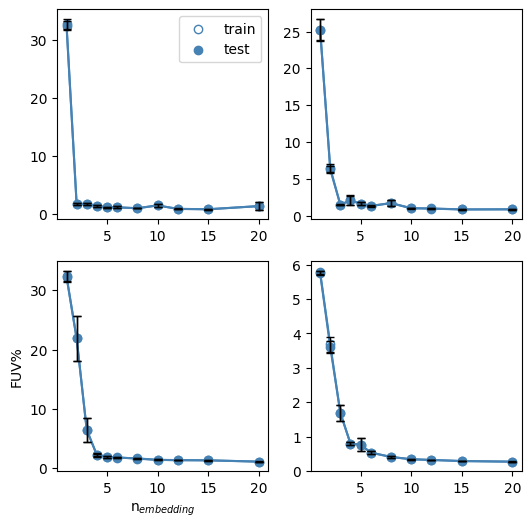

In [8]:
NT=np.array([2,3,4,5])
fig,axes=plt.subplots(2,2,figsize=(6,6))
axes=axes.flat
for i,n_target in enumerate(NT):
    ax=axes[i]
    data_train = np.loadtxt(f"./saved_data/reconstruction_T{n_target}_train.txt")
    data_test = np.loadtxt(f"./saved_data/reconstruction_T{n_target}_test.txt")
    N_EBD = data_train[0,:]
    for j,data in enumerate([data_train,data_test]):
        FUV = data[1:,:]
        mean_FUV = np.mean(FUV,axis=0)
        std_FUV = np.std(FUV,axis=0,ddof=1)
        se_FUV = std_FUV/np.sqrt(FUV.shape[0])
        mfc = 'white' if j==0 else 'steelblue'
        ax.scatter(N_EBD,mean_FUV,facecolor=mfc,edgecolor='steelblue')
        ax.errorbar(N_EBD,mean_FUV,yerr=se_FUV,fmt='none',ecolor='k',elinewidth=1,capsize=3,zorder=10)
        ax.plot(N_EBD,mean_FUV,c='steelblue')
ax=axes[0]
ax.scatter([],[],facecolor='white',edgecolor='steelblue',label='train')
ax.scatter([],[],facecolor='steelblue',edgecolor='steelblue',label='test')
ax.legend()
ax=axes[2]
ax.set_xlabel("n$_{embedding}$")
ax.set_ylabel("FUV%")

In [9]:
from scipy.optimize import curve_fit

def y_exp(x,a,b,c):
    yy = -b*(x-a)
    yy[x>a]=0
    y = c*np.exp(yy)
    return y

[2.18741769 2.93971332 1.00000605]
[3.30266305 1.41190977 0.98466054]
[5.10246587 0.78169829 1.30614594]
[5.61196416 0.64009552 0.30112776]


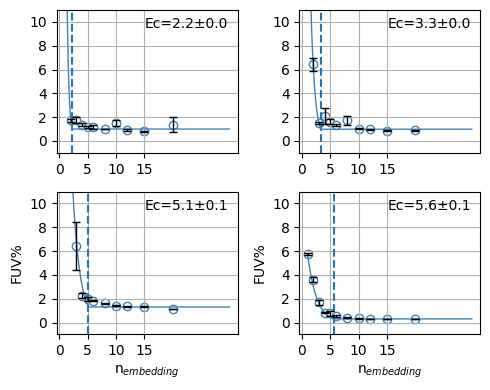

In [14]:
NT=[2,3,4,5]

fig,axes=plt.subplots(2,2,figsize=(5,4))
axes=axes.flat
Ec_data = np.zeros((3,len(NT)))
Ec_data[0,:]=NT
for i,n_target in enumerate(NT):
    ax=axes[i]
    data=np.loadtxt(f"./saved_data/reconstruction_T{n_target}_test.txt")
    N_EBD=data[0,:]
    FUV = data[1:,:]
    mean_FUV = np.mean(FUV,axis=0)
    std_FUV = np.std(FUV,axis=0,ddof=1)
    se_FUV = std_FUV/np.sqrt(FUV.shape[0])
    ax.scatter(N_EBD,mean_FUV,fc='white',ec='steelblue')
    ax.errorbar(N_EBD,mean_FUV,yerr=se_FUV,fmt='none',ecolor='k',elinewidth=1,capsize=3,zorder=10)
    
    popt, pcov = curve_fit(y_exp, N_EBD, mean_FUV, sigma=se_FUV, absolute_sigma=True, p0=(n_target, 1, 1))
    print(popt)
    Ec = popt[0]
    param_errors = np.sqrt(np.diag(pcov))# estimate the standard errors of the fitted parameters
    Ec_se = param_errors[0]
    Ec_data[1,i]=Ec
    Ec_data[2,i]=Ec_se
    y_Ec = y_exp(np.array([Ec]),*popt)
    ax.plot([Ec,Ec],[-1,100],ls="--")
    xx=np.linspace(1,30,1000)
    yy=y_exp(xx,*popt)
    ax.plot(xx,yy,color="steelblue",linewidth=1)
    
    ax.text(x=0.95,y=0.95,s="Ec=%1.1f±%1.1f"%(Ec,Ec_se),ha="right",va="top",transform=ax.transAxes)
    if i==2:
        ax.set_xlabel("n$_{embedding}$")
        ax.set_ylabel("FUV%")

    ax.set_xticks(np.arange(0,20,5))
    ax.set_yticks([0,2,4,6,8,10])
    ax.set_ylim([-1,11])
    ax.grid(True)
    if i==3:
        ax.set_xlabel("n$_{embedding}$")
        ax.set_ylabel("FUV%")
fig.tight_layout()
np.savetxt(f"./saved_data/Ec_data.txt",Ec_data)

Slope            : 1.198 ± 0.028 (SE)
Intercept        : -0.230 ± 0.078 (SE)
t-statistic      : 42.81  (dof = 2)
p-value (slope≠0): 0.000545
Weighted R²      : 0.982


Text(0, 0.5, 'critical dimension E$_c$')

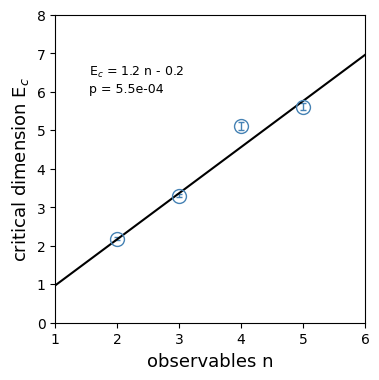

In [5]:
from scipy.optimize import curve_fit
from scipy.stats import t

# Linear model
def linear_model(x, a, b):
    return a * x + b

fig,ax = plt.subplots(1,1,figsize=(4,4))
data = np.loadtxt(f"./saved_data/Ec_data.txt")
# Extract x, y, and CI bounds
N_TG = data[0,:]
Ec = data[1,:]
Ec_se = data[2,:]
ax.errorbar(N_TG,Ec,Ec_se,marker="o",c='steelblue',mfc="None",capsize=2,lw=0,markersize=10,
                elinewidth=1)

# Weighted fit using standard errors
popt, pcov = curve_fit(linear_model, N_TG, Ec, sigma=Ec_se, absolute_sigma=True)
slope, intercept = popt
slope_se, intercept_se = np.sqrt(np.diag(pcov))

# residuals and total sums of squares
y_pred = linear_model(N_TG, slope, intercept)
SS_res = np.sum(((Ec - y_pred) / Ec_se) ** 2)  # weighted residual SS
SS_tot = np.sum(((Ec - np.average(Ec, weights=1 / Ec_se ** 2)) / Ec_se) ** 2)

R2 = 1 - SS_res / SS_tot

# Compute t-statistic and p-value
dof = len(N_TG) - 2
t_stat = slope / slope_se
p_value = 2 * (1 - t.cdf(np.abs(t_stat), df=dof))

# ----- formatted report ---------------------------------------------------
report = (
    f"Slope            : {slope:.3f} ± {slope_se:.3f} (SE)\n"
    f"Intercept        : {intercept:.3f} ± {intercept_se:.3f} (SE)\n"
    f"t-statistic      : {t_stat:.2f}  (dof = {dof})\n"
    f"p-value (slope≠0): {p_value:.3g}\n"
    f"Weighted R²      : {R2:.3f}"
)

print(report)

# Generate fit line and CI band
x_fit = np.linspace(0, 10, 100)
y_fit = linear_model(x_fit, slope, intercept)
ax.plot(x_fit,y_fit,c="k")
ax.set_xlim([1, 6])
ax.set_ylim([0, 8])   
# Format regression equation
txt = f"E$_c$ = {slope:.1f} n {'+' if intercept >= 0 else '-'} {abs(intercept):.1f}\np = {p_value:.1e}"
ax.text(x=0.11, y=0.75, s=txt, transform=ax.transAxes, fontsize=9)
ax.set_xlabel("observables n", fontsize=13)
ax.set_ylabel("critical dimension E$_c$", fontsize=13)